In [1]:
import pymongo
import pandas as pd
import numpy as np
import os
import re
import json
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
import pprint
import pickle

%matplotlib inline

In [6]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = 'all' #默认为'last'

font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 23,
}

In [7]:
client = pymongo.MongoClient("mongodb://localhost:27017/")
weibo_db = client["weibo"]
user_table = weibo_db['user']
post_table = weibo_db['post']
comment_table = weibo_db['comment']

In [8]:
post_list = [u for u in post_table.find()]
post_list = sorted(post_list, key=lambda x:x['_id'])
column_list = sorted(list(set(k for u in post_list for k in u.keys())))
post_df = pd.DataFrame(post_list,columns=column_list)

In [9]:
def convert(s):
    if isinstance(s,int):
        return s
    if s.startswith('100万'):
        return 100*10000+np.random.randint(200000)
    else:
        return 0
attrs = ['attitudes_count','comments_count','reposts_count']

def convert(s):
    if isinstance(s,int):
        return s
    if s.startswith('100万'):
        return 100*10000+np.random.randint(200000)
    else:
        return 0
for attr in attrs:
    post_df[attr] = post_df[attr].apply(convert)

In [10]:
def graph_analysis(G):
    result = {}
    #节点数：
    node_len = len(G)
    #边数
    edge_len = G.number_of_edges()
    #网络直径
    diameter = nx.diameter(G)
    #所有节点间的最短*路径*,列表存储
    all_pairs_shortest_path = nx.all_pairs_shortest_path(G)
    #网络节点间的平均最短路长度
    average_shortest_path_length = nx.average_shortest_path_length(G)
    #网络传递性
    transitivity = Transitivity = nx.transitivity(G)
    #网络各个节点群聚系数
    clustering = Clustering = nx.clustering(G)
    #网络度分布
    degree_histogram = Degree_distribution = nx.degree_histogram(G)
    #网络度中心性
    degree_centrality = nx.degree_centrality(G)
    #各个节点Closeness
    closeness_centrality = nx.closeness_centrality(G)
    #各个节点Betweenness
    betweenness_centrality = nx.betweenness_centrality(G)
    result['node_len'] = node_len
    result['edge_len'] = edge_len
    result['diameter'] = diameter
    result['all_pairs_shortest_path'] = all_pairs_shortest_path
    result['average_shortest_path_length'] = average_shortest_path_length
    result['transitivity'] = transitivity
    result['clustering'] = clustering
    result['degree_histogram'] = degree_histogram
    result['degree_centrality'] = degree_centrality
    result['closeness_centrality'] = closeness_centrality
    result['betweenness_centrality'] = betweenness_centrality
    
    return result


node_color_map={
    'post':'blue',
    'user':'green',
    'topic':'purple',
    'comment':'black'
}

edge_color_map={
    'following':'black',
    '@':'orange',
    'is':'red',
    'focus':'pink',
    'comment':'grey'
}

## user -> following -> user

In [11]:
def generate_triples_of_user_user():
    '''
    uid -> following -> uid
    '''
    result = []
    user_list = [u for u in user_table.find()]
    
    if not os.path.exists('triples'):
        os.mkdir('triples')
    
    fname = 'triples/user_user.csv'
    
    for i in range(len(user_list)):
        for j in range(len(user_list)):
            uid = user_list[i]['_id']
            if 'follower' in user_list[j] and uid in user_list[j]['follower']:
                result.append([str(uid),str(user_list[j]['_id']),'following'])
            if 'following' in user_list[j] and  uid in user_list[j]['following']:
                result.append([str(user_list[j]['_id']),str(uid),'following'])
            
    df=pd.DataFrame(result)
    df.to_csv(fname,sep=',',header=None,index=None)
    return df

In [30]:
triples_user_user = generate_triples_of_user_user()

<Figure size 1440x1080 with 0 Axes>

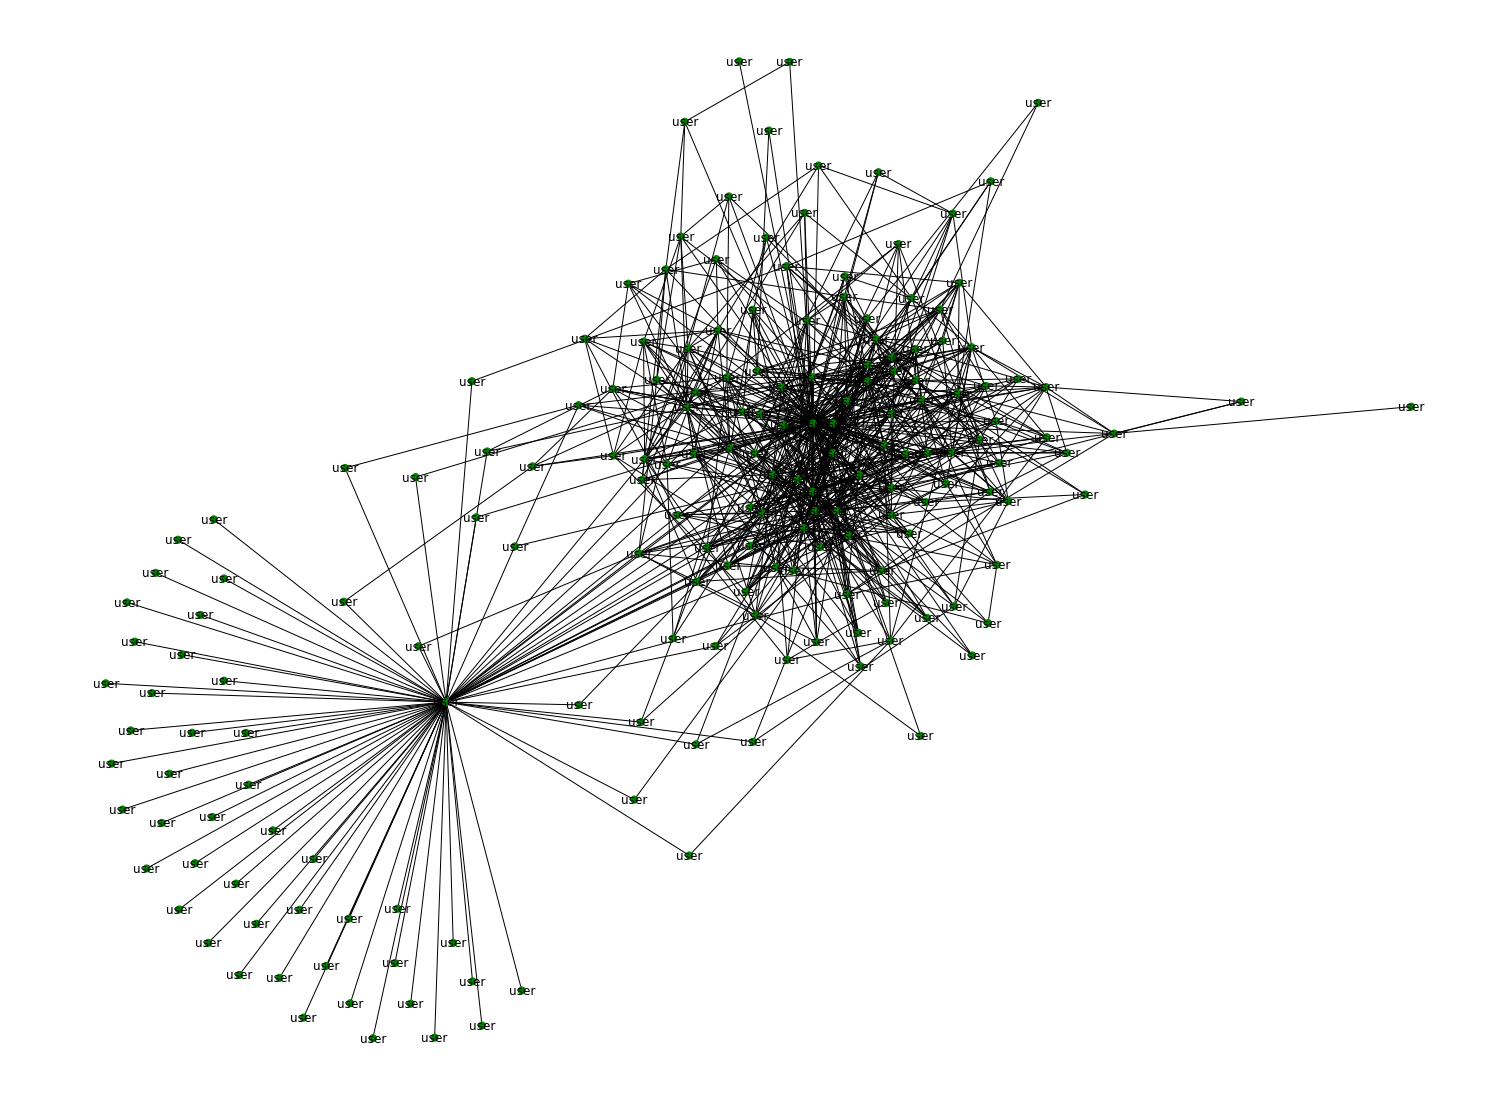

In [91]:
BG = nx.Graph()
users = list(set(triples_user_user[0].values.tolist()+triples_user_user[1].values.tolist()))
BG.add_nodes_from(users, bipartite=1, _type='user')

edges = []
for _,tpl in triples_user_user.iterrows():
    a,b,rel = tpl
    edges.append((a,b))
BG.add_edges_from(edges,_type='following')

#labels = dict((n, "[" + d['_type']  + " : " + str(n) + "]") for n,d in BG.nodes(data=True))
labels = dict((n, d['_type']) if '_type' in d else (n,'') for n,d in BG.nodes(data=True))
node_colors = [node_color_map[d['_type']] for _,d in BG.nodes(data=True) if '_type' in d]
edge_colors = [edge_color_map[d['_type']] for _,_,d in BG.edges(data=True) if '_type' in d]

plt.figure(figsize=(20,15))
nx.draw(BG, node_color = node_colors ,edge_color = edge_colors,labels = labels, font_size=12, node_size = 50)
plt.savefig('user_user.png')
plt.show()

## 实验测试

In [101]:
# 获取两个节点的路径

In [104]:
# result = graph_analysis(BG)
# path = result['all_pairs_shortest_path']
# path = [p for p in path]
# path_map = {}
# for k,t in path:
#     for tk,tv in t.items():
#         path_map[(k,tk)]=tv
#         path_map[(tk,k)]=tv
# del path,result

In [107]:
# uid1 = '5471534537' 
# uid2 = '2982152367' 

# if (uid1, uid2) in path_map:
#     print(path_map[(uid1, uid2)])
# else:
#     print('No following path')

['2982152367', '5471534537']


## user.post -> @ -> user

In [15]:
def generate_triples_of_post_user():
    '''
    uid,post -> @ -> uid
    '''
    result = []
    post_list = [p for p in post_table.find()]
    user_pattern = r'[\s\b！!。？]*@([\u4e00-\u9fa5-_a-zA-Z0-9]+[\s\b！!。？]*)'
    
    if not os.path.exists('triples'):
        os.mkdir('triples')
    
    fname = 'triples/post_user.csv'
    
    for i in range(len(post_list)):
        pid = post_list[i]['_id']
        uid = post_list[i]['uid']
        text = post_list[i]['text'] 
        for screen_name in re.findall(user_pattern,text):
            user = user_table.find_one({'screen_name':screen_name.strip()})
            if user:
                result.append([uid,pid,user['_id'],'@'])
    
    df=pd.DataFrame(result)
    df.to_csv(fname,sep=',',header=None,index=None)
    return df

In [16]:
triples_post_user = generate_triples_of_post_user()

<Figure size 1440x1080 with 0 Axes>

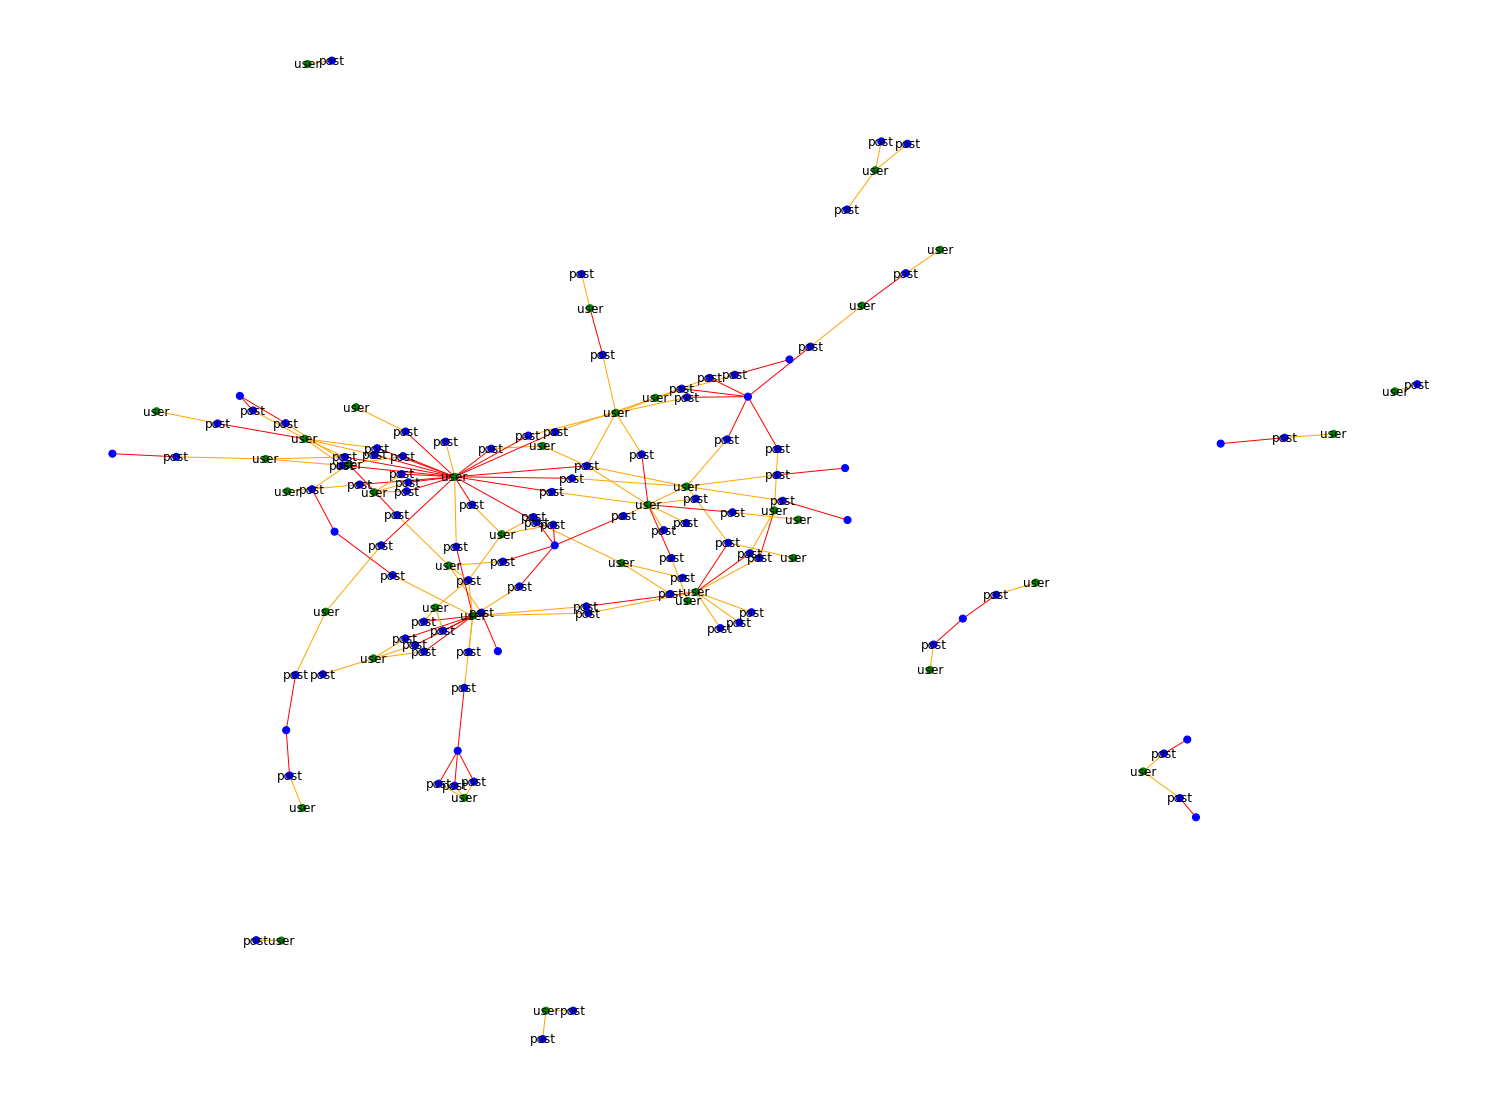

In [17]:
BG = nx.Graph()
size_filter = 100
posts = triples_post_user[1].values.tolist()[:size_filter]
users = triples_post_user[2].values.tolist()[:size_filter]

BG.add_nodes_from(posts, bipartite=1, _type='post')
BG.add_nodes_from(users, bipartite=1, _type='user')

edges = []
for _,tpl in triples_post_user[:size_filter].iterrows():
    _,a,b,rel = tpl
    edges.append((_,a))
BG.add_edges_from(edges,_type='is')

edges = []
for _,tpl in triples_post_user[:size_filter].iterrows():
    _,a,b,rel = tpl
    edges.append((a,b))
BG.add_edges_from(edges,_type='@')

#labels = dict((n, "[" + d['_type']  + " : " + str(n) + "]") for n,d in BG.nodes(data=True))
labels = dict((n, d['_type']) if '_type' in d else (n,'') for n,d in BG.nodes(data=True))
node_colors = [node_color_map[d['_type']] for _,d in BG.nodes(data=True) if '_type' in d]
edge_colors = [edge_color_map[d['_type']] for _,_,d in BG.edges(data=True) if '_type' in d]

plt.figure(figsize=(20,15))
nx.draw(BG, node_color = node_colors ,edge_color = edge_colors,labels = labels, font_size=12, node_size = 50)
plt.savefig('post_user.png')
plt.show()

In [19]:
gc = max(nx.connected_component_subgraphs(BG), key=len)
graph_analysis(gc)

{'node_len': 117,
 'edge_len': 148,
 'diameter': 14,
 'all_pairs_shortest_path': <generator object all_pairs_shortest_path at 0x7f13ae465e60>,
 'average_shortest_path_length': 5.230769230769231,
 'transitivity': 0,
 'clustering': {4362484011731973: 0,
  4316741515542550: 0,
  4361813543818776: 0,
  4364608519001125: 0,
  3725773862: 0,
  4362194160295466: 0,
  4361778127201836: 0,
  1869580850: 0,
  2705119801: 0,
  2706896955: 0,
  4364333993100863: 0,
  4354166971296330: 0,
  4362503372891724: 0,
  4364601724416596: 0,
  4363912172832352: 0,
  2110705772: 0,
  4364693416111217: 0,
  4364720456361586: 0,
  4344811987373681: 0,
  5291824241: 0,
  1730077315: 0,
  4364671136036484: 0,
  4364982793153671: 0,
  4362734382240402: 0,
  1296241304: 0,
  4362824761383068: 0,
  1192329374: 0,
  4364630627332259: 0,
  4364626625802404: 0,
  2909406375: 0,
  6866528424: 0,
  1642591402: 0,
  2870450862: 0,
  4270863119009460: 0,
  1893711543: 0,
  4364699686520505: 0,
  1822398137: 0,
  43639267

## user.post -> focus -> topic

In [20]:
topic_pattern = r'#[\u4e00-\u9fa5a-zA-Z0-9]+?#'# 话题过滤
total_topic_list = []

def generate_triples_of_post_topic():
    '''
    uid,post -> @ -> topic
    '''
    result = []
    post_list = [p for p in post_table.find()]
    
    if not os.path.exists('triples'):
        os.mkdir('triples')
    
    fname = 'triples/post_topic.csv'
    
    for i in range(len(post_list)):
        pid = post_list[i]['_id']
        uid = post_list[i]['uid']
        text = post_list[i]['text']
        topic_list = re.findall(topic_pattern,text)
        total_topic_list.extend(topic_list)
        for topic in topic_list:
            result.append([uid,pid,topic,'focus'])
    
    df=pd.DataFrame(result)
    df.to_csv(fname,sep=',',header=None,index=None)
    return df

In [21]:
triples_post_topic = generate_triples_of_post_topic()

<Figure size 1440x1080 with 0 Axes>

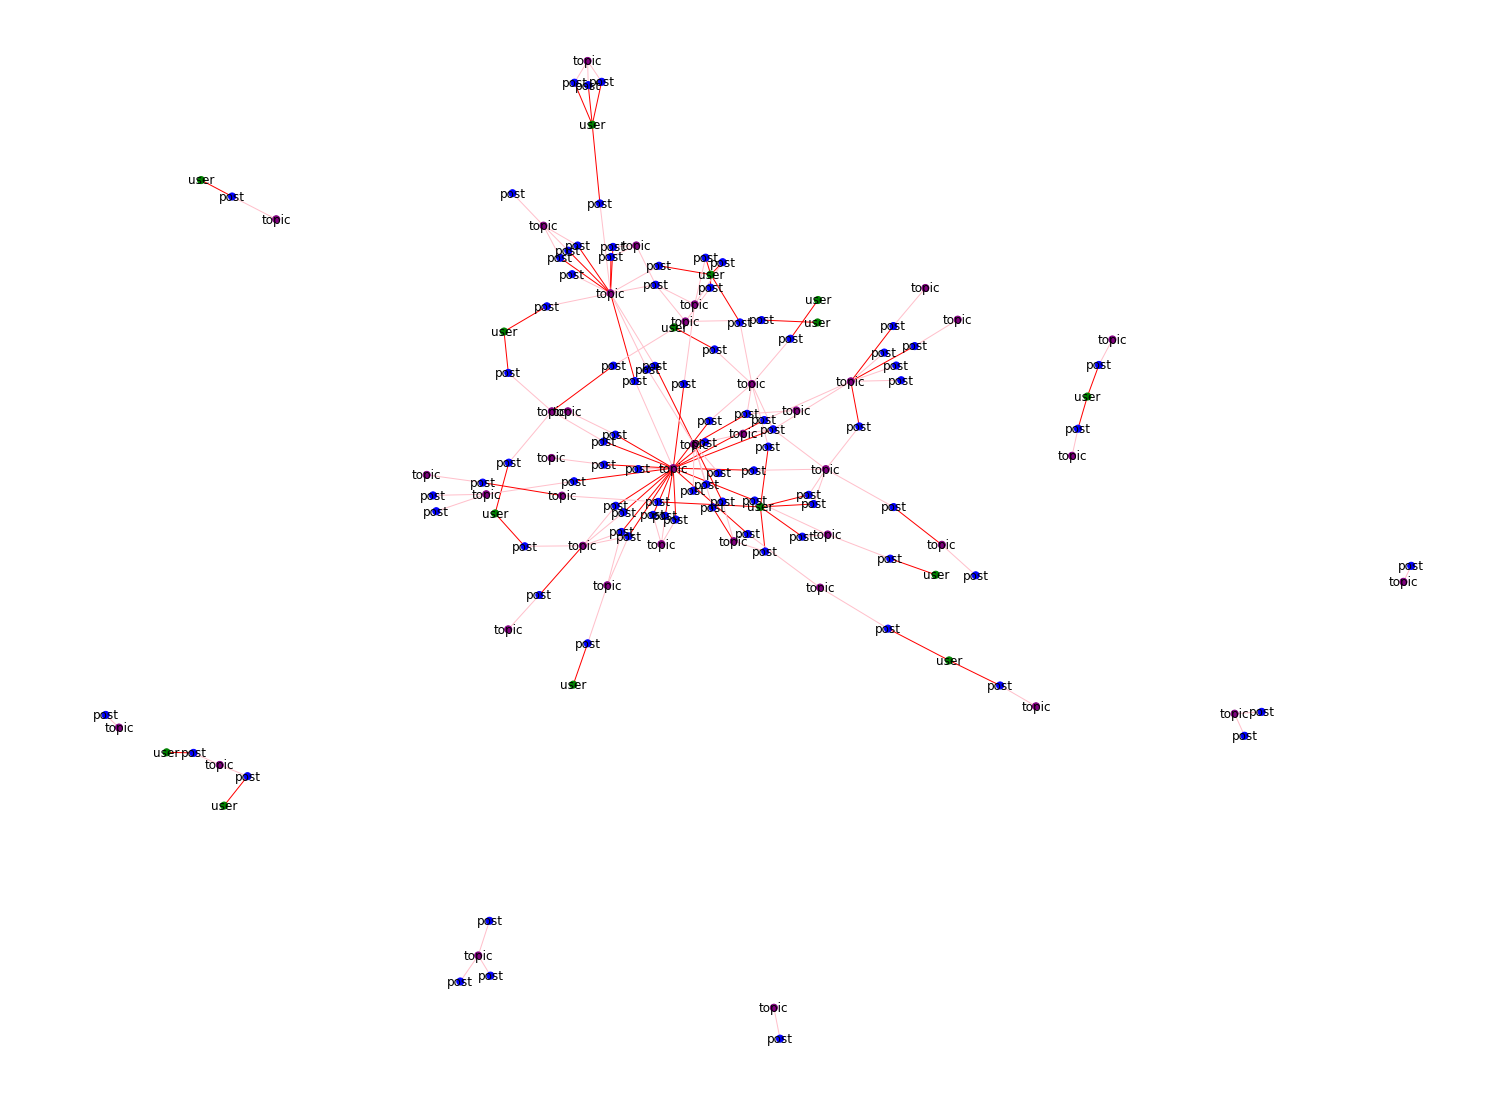

In [23]:
BG = nx.Graph()
size_filter = 100
users = triples_post_user[0].values.tolist()[:size_filter]
posts = triples_post_user[1].values.tolist()[:size_filter]
topics = triples_post_user[2].values.tolist()[:size_filter]
BG.add_nodes_from(users, bipartite=1, _type='user')
BG.add_nodes_from(posts, bipartite=1, _type='post')
BG.add_nodes_from(topics, bipartite=1, _type='topic')

edges = []
for _,tpl in triples_post_user[:size_filter].iterrows():
    _,a,b,rel = tpl
    edges.append((_,a))
BG.add_edges_from(edges,_type='is')

edges = []
for _,tpl in triples_post_user[:size_filter].iterrows():
    _,a,b,rel = tpl
    edges.append((a,b))
BG.add_edges_from(edges,_type='focus')

labels = dict((n, d['_type']) if '_type' in d else (n,'') for n,d in BG.nodes(data=True))
node_colors = [node_color_map[d['_type']] for _,d in BG.nodes(data=True) if '_type' in d]
edge_colors = [edge_color_map[d['_type']] for _,_,d in BG.edges(data=True) if '_type' in d]

plt.figure(figsize=(20,15))
nx.draw(BG, node_color = node_colors ,edge_color = edge_colors,labels = labels, font_size=12, node_size = 50)
plt.savefig('post_topic.png')
plt.show()

In [24]:
gc = max(nx.connected_component_subgraphs(BG), key=len)
graph_analysis(gc)

{'node_len': 117,
 'edge_len': 148,
 'diameter': 14,
 'all_pairs_shortest_path': <generator object all_pairs_shortest_path at 0x7f13a6be2f10>,
 'average_shortest_path_length': 5.230769230769231,
 'transitivity': 0,
 'clustering': {4362484011731973: 0,
  4316741515542550: 0,
  4361813543818776: 0,
  4364608519001125: 0,
  3725773862: 0,
  4362194160295466: 0,
  4361778127201836: 0,
  1869580850: 0,
  2705119801: 0,
  2706896955: 0,
  4364333993100863: 0,
  4354166971296330: 0,
  4362503372891724: 0,
  4364601724416596: 0,
  4363912172832352: 0,
  2110705772: 0,
  4364693416111217: 0,
  4364720456361586: 0,
  4344811987373681: 0,
  5291824241: 0,
  1730077315: 0,
  4364671136036484: 0,
  4364982793153671: 0,
  4362734382240402: 0,
  1296241304: 0,
  4362824761383068: 0,
  1192329374: 0,
  4364630627332259: 0,
  4364626625802404: 0,
  2909406375: 0,
  6866528424: 0,
  1642591402: 0,
  2870450862: 0,
  4270863119009460: 0,
  1893711543: 0,
  4364699686520505: 0,
  1822398137: 0,
  43639267

## user.comment  -> comment -> user.post

In [26]:
def generate_triples_of_comment_user():
    '''
    uid,comment -> comment -> uid.post
    '''
    result = []
    comment_list = [c for c in comment_table.find()]
    user_pattern = r'[\s\b！!。？]*@([\u4e00-\u9fa5-_a-zA-Z0-9]+[\s\b！!。？]*)'
    
    if not os.path.exists('triples'):
        os.mkdir('triples')
    
    fname = 'triples/comment_post.csv'
    
    for i in range(len(post_list)):
        cid = comment_list[i]['_id']
        uid = comment_list[i]['uid']
        pid = comment_list[i]['pid']
        comment = post_list[i]['text']
        post = post_table.find_one({'_id':int(pid)})
        if post:
            user = user_table.find_one({'_id':post['uid']})
            if user:
                result.append([uid,cid,user['_id'],pid,'comment'])
    
    df=pd.DataFrame(result)
    df.to_csv(fname,sep=',',header=None,index=None)
    return df

In [27]:
triples_comment_user = generate_triples_of_comment_user()

<Figure size 1440x1080 with 0 Axes>

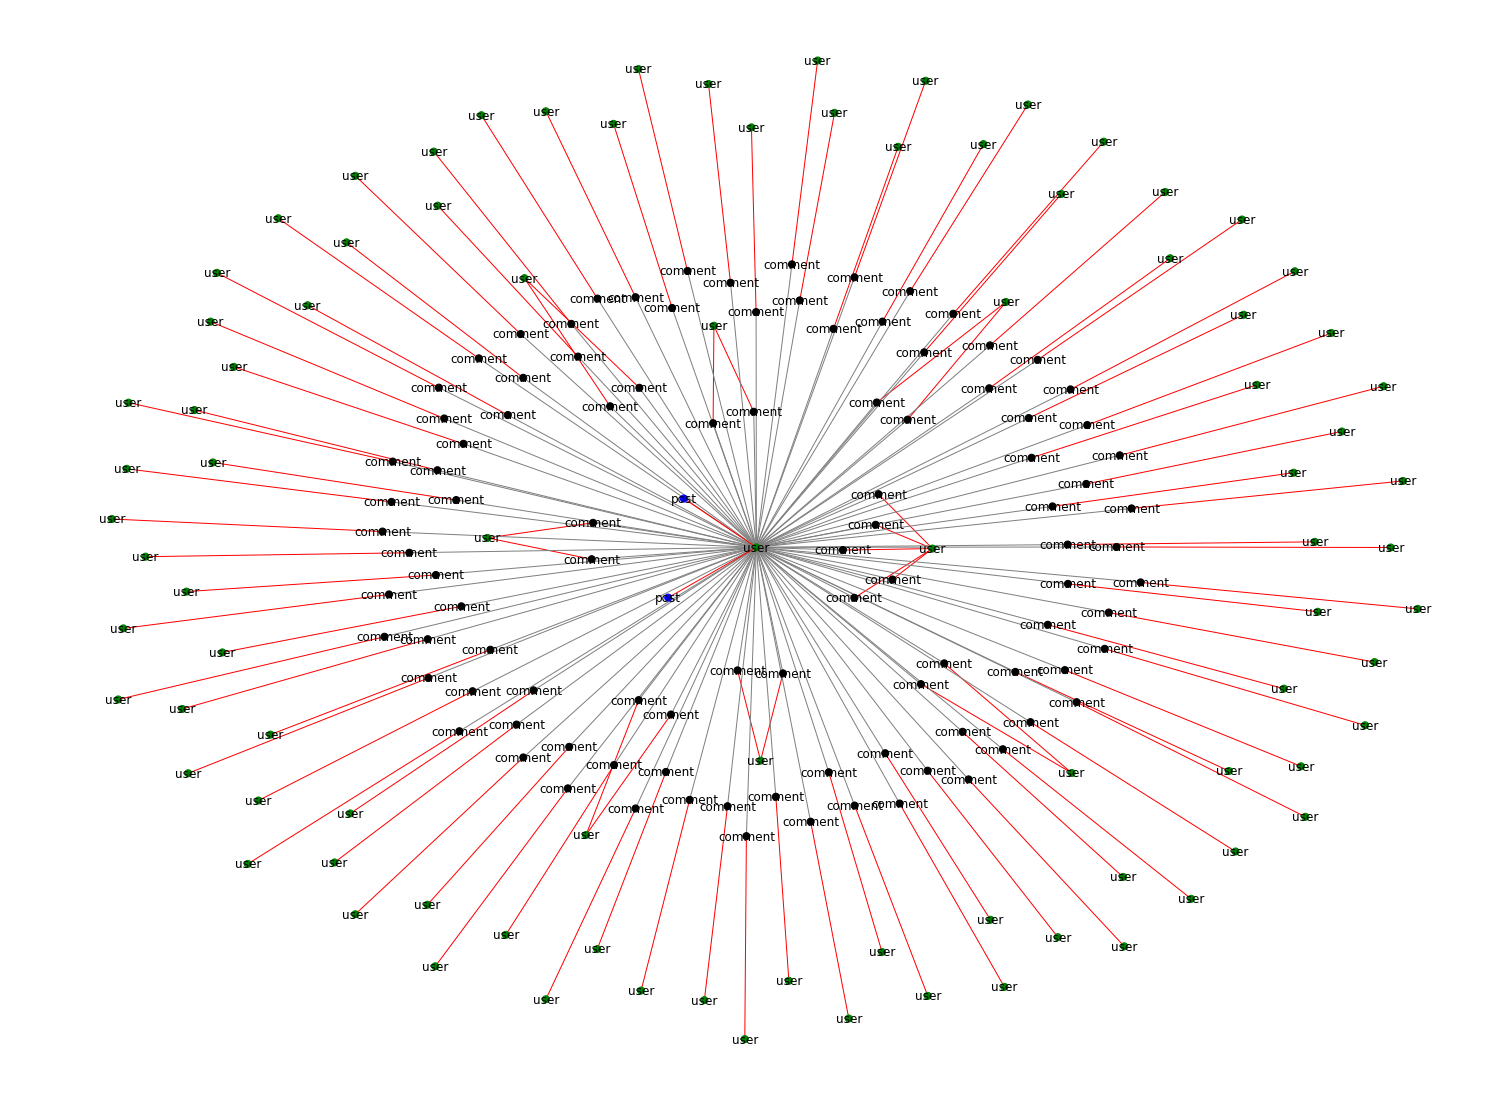

In [28]:
BG = nx.Graph()
size_filter = 100
user1s = triples_comment_user[0].values.tolist()[:size_filter]
comments = triples_comment_user[1].values.tolist()[:size_filter]
user2s = triples_comment_user[2].values.tolist()[:size_filter]
posts = triples_comment_user[3].values.tolist()[:size_filter]
BG.add_nodes_from(user1s, bipartite=1, _type='user')
BG.add_nodes_from(comments, bipartite=1, _type='comment')
BG.add_nodes_from(user2s, bipartite=1, _type='user')
BG.add_nodes_from(posts, bipartite=1, _type='post')

edges = []
for _,tpl in triples_comment_user[:size_filter].iterrows():
    _,a,b,c,rel = tpl
    edges.append((_,a))
BG.add_edges_from(edges,_type='is')

edges = []
for _,tpl in triples_comment_user[:size_filter].iterrows():
    _,a,b,c,rel = tpl
    edges.append((b,c))
BG.add_edges_from(edges,_type='is')

edges = []
for _,tpl in triples_comment_user[:size_filter].iterrows():
    _,a,b,c,rel = tpl
    edges.append((a,b))
BG.add_edges_from(edges,_type='comment')

labels = dict((n, d['_type']) if '_type' in d else (n,'') for n,d in BG.nodes(data=True))
node_colors = [node_color_map[d['_type']] for _,d in BG.nodes(data=True) if '_type' in d]
edge_colors = [edge_color_map[d['_type']] for _,_,d in BG.edges(data=True) if '_type' in d]

plt.figure(figsize=(20,15))
nx.draw(BG, node_color = node_colors ,edge_color = edge_colors,labels = labels, font_size=12, node_size = 50)
plt.savefig('comment_user.png')
plt.show()

In [29]:
gc = max(nx.connected_component_subgraphs(BG), key=len)
graph_analysis(gc)

{'node_len': 192,
 'edge_len': 202,
 'diameter': 4,
 'all_pairs_shortest_path': <generator object all_pairs_shortest_path at 0x7f139df0df10>,
 'average_shortest_path_length': 2.905759162303665,
 'transitivity': 0,
 'clustering': {6120736258: 0,
  6433254915: 0,
  1770127365: 0,
  4365105107991052: 0,
  4365106207148044: 0,
  4365105304927760: 0,
  2980105745: 0,
  1591407122: 0,
  3686658067: 0,
  4365104449946133: 0,
  6451599386: 0,
  6720755227: 0,
  4365105317704227: 0,
  4365103887493155: 0,
  4364997683698729: 0,
  6648471082: 0,
  4365105036130351: 0,
  3951423536: 0,
  4365106290353721: 0,
  4364995666341950: 0,
  4365107456568898: 0,
  2990866501: 0,
  4365105543792710: 0,
  4365106198355527: 0,
  4365028117098058: 0,
  4365104743229006: 0,
  5977091155: 0,
  1831041621: 0,
  4365107830385756: 0,
  6014084708: 0,
  4365104474618469: 0,
  4365105078556774: 0,
  6028147301: 0,
  5395966054: 0,
  6237549670: 0,
  4364994340893802: 0,
  5754173034: 0,
  4365018806410352: 0,
  6488

# All In One

<Figure size 2880x1440 with 0 Axes>

{'comment': 'black', 'post': 'blue', 'topic': 'purple', 'user': 'green'}
{'@': 'orange',
 'comment': 'grey',
 'focus': 'pink',
 'following': 'black',
 'is': 'red'}


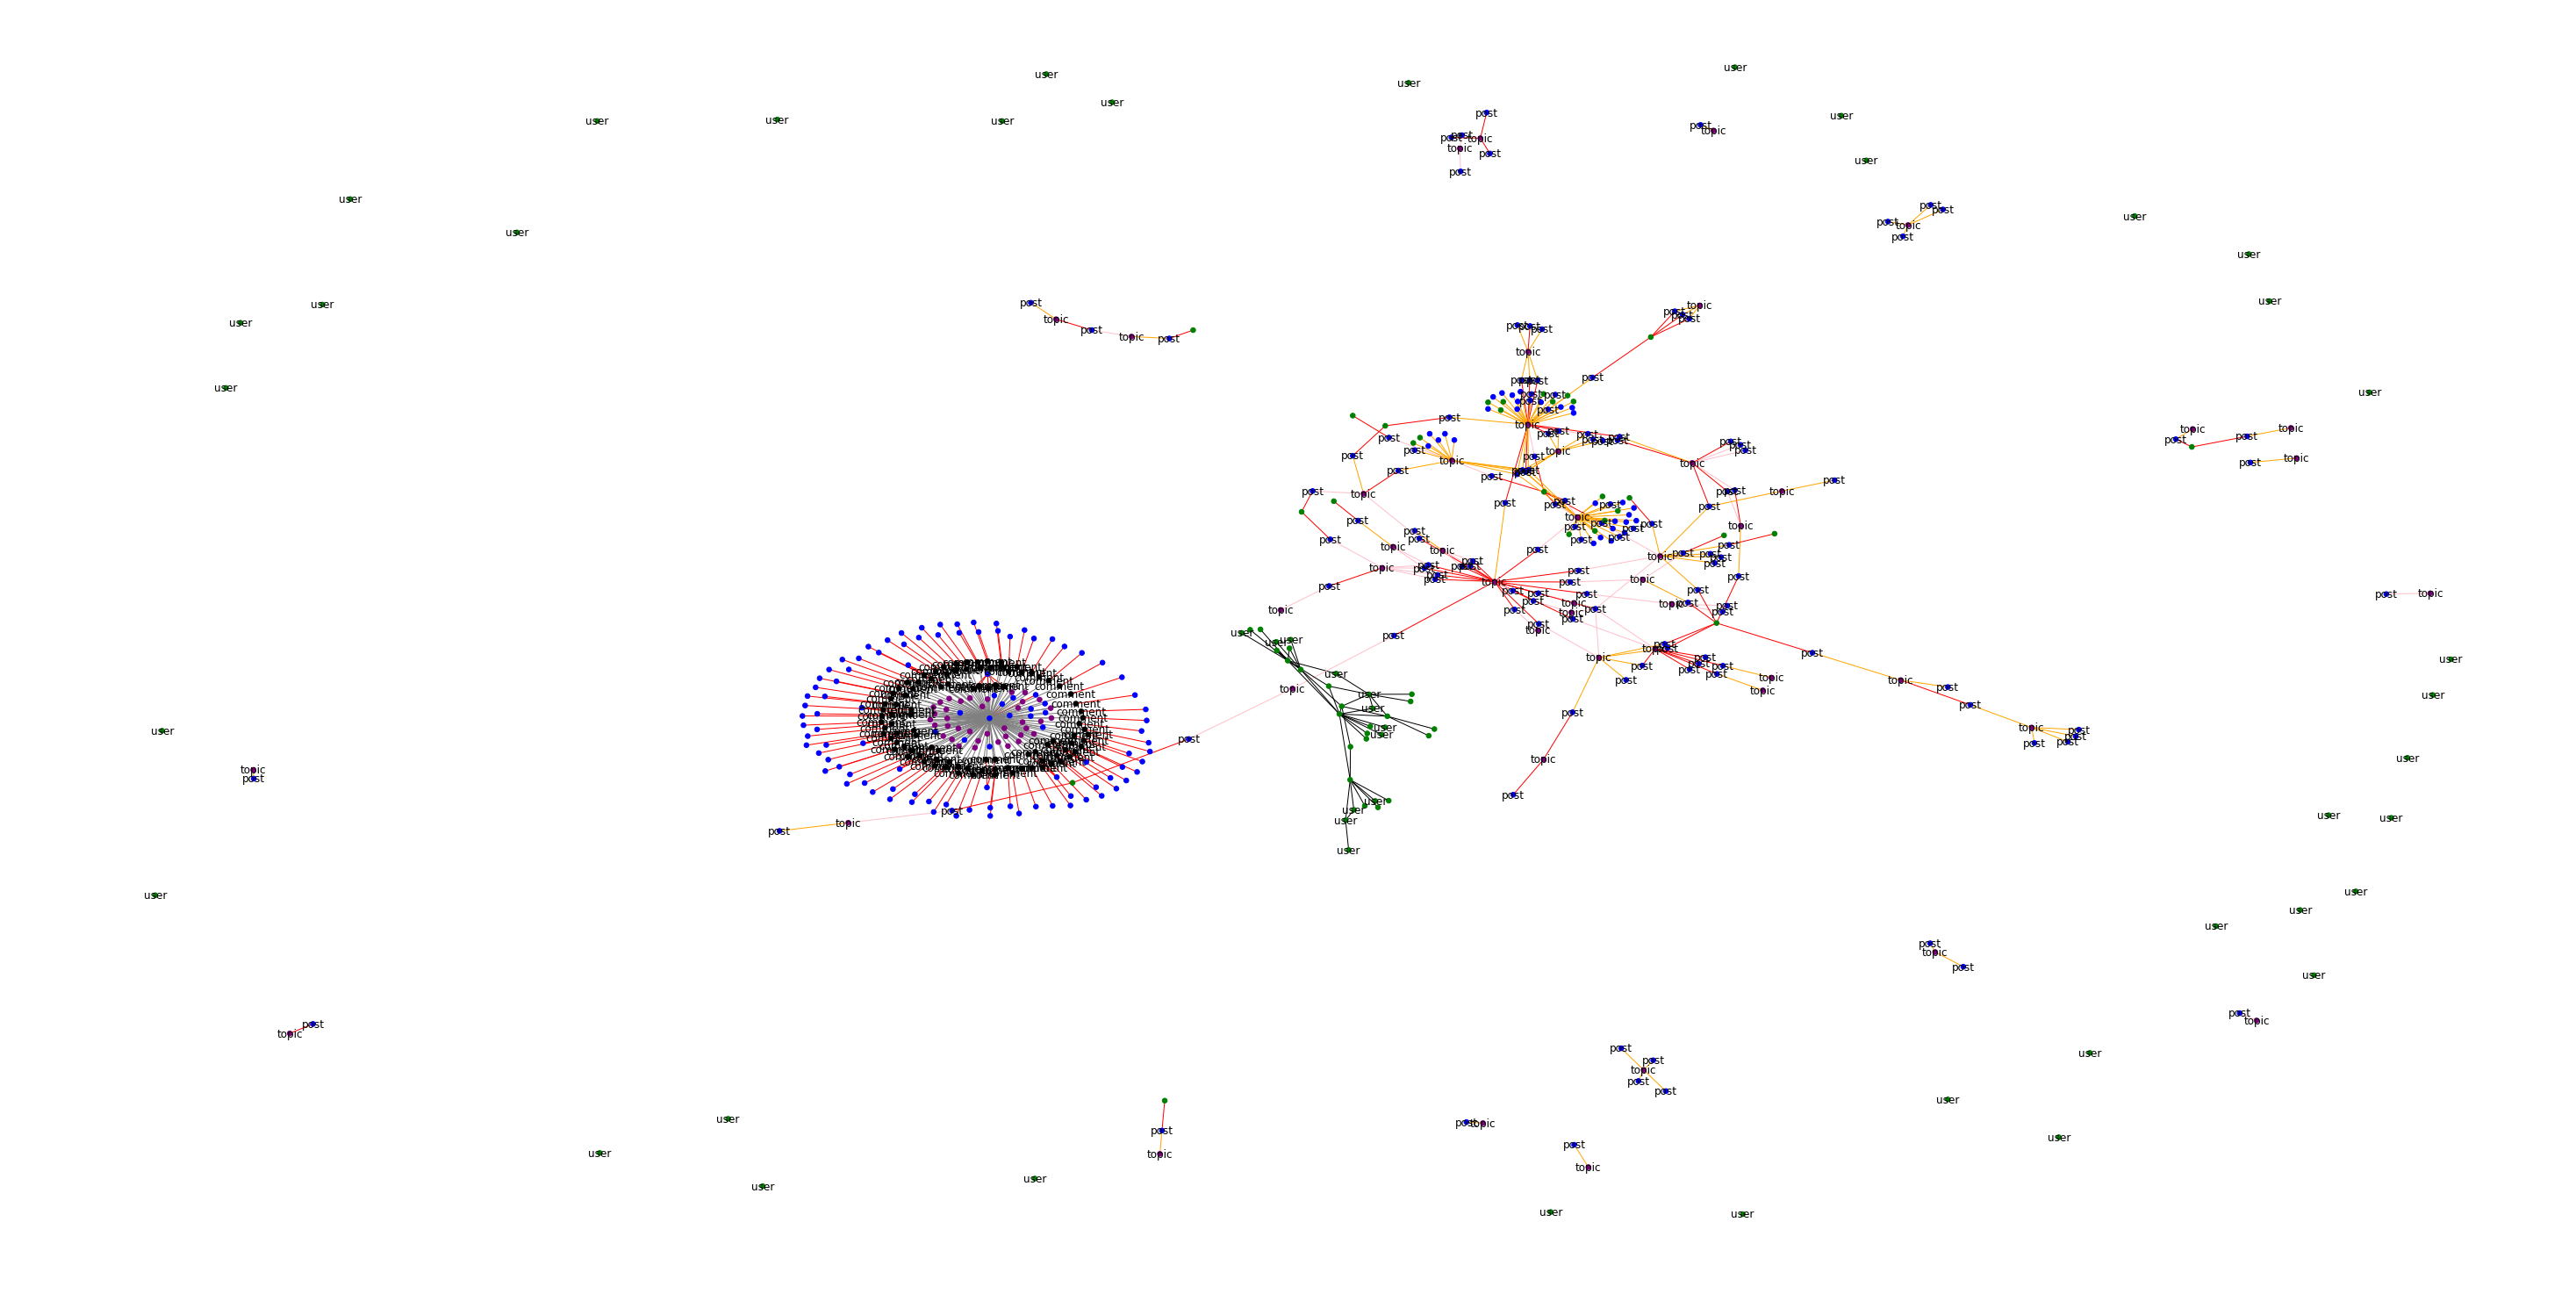

In [38]:
BG = nx.Graph()
size_filter = 50

users = list(set(triples_user_user[0].values.tolist()+triples_user_user[1].values.tolist()))
BG.add_nodes_from(users[:size_filter], bipartite=1, _type='user')

posts = triples_post_user[1].values.tolist()
BG.add_nodes_from(posts[:size_filter*3], bipartite=1, _type='post')

topics = triples_post_user[2].values.tolist()
BG.add_nodes_from(topics[:size_filter*3], bipartite=1, _type='topic')

comments = triples_comment_user[1].values.tolist()
BG.add_nodes_from(comments[:size_filter*2], bipartite=1, _type='comment')

# following
edges = []
for _,tpl in triples_user_user[:size_filter].iterrows():
    a,b,rel = tpl
    edges.append((a,b))
BG.add_edges_from(edges,_type='following')

# @
edges = []
for _,tpl in triples_post_user[:size_filter*2].iterrows():
    _,a,b,rel = tpl
    edges.append((_,a))
BG.add_edges_from(edges,_type='is')

edges = []
for _,tpl in triples_post_user[:size_filter*4].iterrows():
    _,a,b,rel = tpl
    edges.append((a,b))
BG.add_edges_from(edges,_type='@')

# focus
edges = []
for _,tpl in triples_post_user[:size_filter*2].iterrows():
    _,a,b,rel = tpl
    edges.append((_,a))
BG.add_edges_from(edges,_type='is')

edges = []
for _,tpl in triples_post_user[:size_filter].iterrows():
    _,a,b,rel = tpl
    edges.append((a,b))
BG.add_edges_from(edges,_type='focus')

# comment
edges = []
for _,tpl in triples_comment_user[:size_filter*2].iterrows():
    _,a,b,c,rel = tpl
    edges.append((_,a))
BG.add_edges_from(edges,_type='is')

edges = []
for _,tpl in triples_comment_user[:size_filter*2].iterrows():
    _,a,b,c,rel = tpl
    edges.append((b,c))
BG.add_edges_from(edges,_type='is')

edges = []
for _,tpl in triples_comment_user[:size_filter*3].iterrows():
    _,a,b,c,rel = tpl
    edges.append((a,b))
BG.add_edges_from(edges,_type='comment')

# output
labels = dict((n, d['_type']) if '_type' in d else (n,'') for n,d in BG.nodes(data=True))
node_colors = [node_color_map[d['_type']] for _,d in BG.nodes(data=True) if '_type' in d]
edge_colors = [edge_color_map[d['_type']] for _,_,d in BG.edges(data=True) if '_type' in d]

plt.figure(figsize=(40,20))
nx.draw(BG, node_color = node_colors ,labels = labels ,edge_color = edge_colors, font_size=12, node_size = 30)
plt.savefig('all_in_one.png')
pprint.pprint(node_color_map)
pprint.pprint(edge_color_map)
plt.show()

In [31]:
gc = max(nx.connected_component_subgraphs(BG), key=len)
graph_analysis(gc)

{'node_len': 242,
 'edge_len': 252,
 'diameter': 4,
 'all_pairs_shortest_path': <generator object all_pairs_shortest_path at 0x7f139dec7f68>,
 'average_shortest_path_length': 2.7204142519118,
 'transitivity': 0,
 'clustering': {6120736258: 0,
  6433254915: 0,
  1770127365: 0,
  4365105107991052: 0,
  4365106207148044: 0,
  4365105304927760: 0,
  2980105745: 0,
  1591407122: 0,
  3686658067: 0,
  4365104449946133: 0,
  6451599386: 0,
  6720755227: 0,
  4365105317704227: 0,
  4365103887493155: 0,
  4364985808994852: 0,
  4365031318046246: 0,
  4364997683698729: 0,
  6648471082: 0,
  4364986740279341: 0,
  4364986371507246: 0,
  4365105036130351: 0,
  3951423536: 0,
  4365107192918584: 0,
  4365106290353721: 0,
  4364995666341950: 0,
  4364988213100096: 0,
  4365107456568898: 0,
  2990866501: 0,
  4365105543792710: 0,
  4365106198355527: 0,
  4365028117098058: 0,
  4365104743229006: 0,
  4364987851915343: 0,
  5977091155: 0,
  1831041621: 0,
  4365107830385756: 0,
  4364986044457055: 0,
 

In [8]:
def dump_commplete_graph():
    BG = nx.Graph()
    users = list(set(triples_user_user[0].values.tolist()+triples_user_user[1].values.tolist()))
    BG.add_nodes_from(users, bipartite=1, _type='user')

    posts = triples_post_user[1].values.tolist()
    BG.add_nodes_from(posts, bipartite=1, _type='post')

    topics = triples_post_user[2].values.tolist()
    BG.add_nodes_from(topics, bipartite=1, _type='topic')

    comments = triples_comment_user[1].values.tolist()
    BG.add_nodes_from(comments, bipartite=1, _type='comment')

    # following
    edges = []
    for _,tpl in triples_user_user.iterrows():
        a,b,rel = tpl
        edges.append((a,b))
    BG.add_edges_from(edges,_type='following')

    # @
    edges = []
    for _,tpl in triples_post_user.iterrows():
        _,a,b,rel = tpl
        edges.append((_,a))
    BG.add_edges_from(edges,_type='is')

    edges = []
    for _,tpl in triples_post_user.iterrows():
        _,a,b,rel = tpl
        edges.append((a,b))
    BG.add_edges_from(edges,_type='@')

    # focus
    edges = []
    for _,tpl in triples_post_user.iterrows():
        _,a,b,rel = tpl
        edges.append((_,a))
    BG.add_edges_from(edges,_type='is')

    edges = []
    for _,tpl in triples_post_user.iterrows():
        _,a,b,rel = tpl
        edges.append((a,b))
    BG.add_edges_from(edges,_type='focus')

    # comment
    edges = []
    for _,tpl in triples_comment_user.iterrows():
        _,a,b,c,rel = tpl
        edges.append((_,a))
    BG.add_edges_from(edges,_type='is')

    edges = []
    for _,tpl in triples_comment_user.iterrows():
        _,a,b,c,rel = tpl
        edges.append((b,c))
    BG.add_edges_from(edges,_type='is')

    edges = []
    for _,tpl in triples_comment_user.iterrows():
        _,a,b,c,rel = tpl
        edges.append((a,b))
    BG.add_edges_from(edges,_type='comment')

    # output
    labels = dict((n, d['_type']) if '_type' in d else (n,'') for n,d in BG.nodes(data=True))
    node_colors = [node_color_map[d['_type']] for _,d in BG.nodes(data=True) if '_type' in d]
    edge_colors = [edge_color_map[d['_type']] for _,_,d in BG.edges(data=True) if '_type' in d]

    nx.draw(BG, node_color = node_colors ,labels = labels ,edge_color = edge_colors, font_size=12, node_size = 30)
    plt.savefig('complete_all_in_one.png')
    pickle.dump(BG,open('complete_all_in_one_graph.pkl','wb'))

In [9]:
# dump_commplete_graph()